In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
from math import sin
np.random.seed(1976)
tf.random.set_seed(1976)

2022-07-13 14:20:15.725422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 14:20:15.725451: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
L=2                                 # number of fidelity levels
X_c=np.array([[0],[0.2],[0.4],[0.6],[1]]) # initial samples for the coarse model 
X_e=np.array([[0],[0.4],[0.6],[1]]) # initial samples for the fine model 
num_initial_points_e=len(X_e)
num_initial_points_c=len(X_c)
n=[num_initial_points_c,num_initial_points_e]
def fe(x):                          # the expensive function 
    return(6*x-2)*(6*x-2)*tf.sin(12*x-4)
def fc(x):                          # the approximation 
    return(1/2*fe(x)+10*(x-1/2)-5)

## the observers 
from trieste.data import Dataset
OBJECTIVE = "OBJECTIVE"
def observer_c(query_points_c ):
    return {
        OBJECTIVE: Dataset(query_points_c, fc(query_points_c))
    }
def observer_e(query_points_e):
    return {
        OBJECTIVE: Dataset(query_points_e, fe(query_points_e))
    }
def normalization(observations):
    Y_max=np.max(observations)
    Y_min=np.min(observations)
    return (observations-1/2*(Y_max+Y_min))/(1/2*(Y_max-Y_min)) 

initial_data_c = observer_c(X_c)
initial_data_e = observer_e(X_e)
data_X=[initial_data_c[OBJECTIVE].query_points[:],initial_data_e[OBJECTIVE].query_points[:]]
Y=[initial_data_c[OBJECTIVE].observations[:].numpy() ,initial_data_e[OBJECTIVE].observations[:].numpy()] 
data_Y=[normalization(initial_data_c[OBJECTIVE].observations[:].numpy()) ,normalization(initial_data_e[OBJECTIVE].observations[:].numpy())]

model=[_, _]
k=[_,_]
sigma_epsilon=[_,_]
k_inv=[_,_]
Y_max=[np.max(initial_data_c[OBJECTIVE].observations[:].numpy()),np.max(initial_data_e[OBJECTIVE].observations[:].numpy())]
Y_min=[np.min(initial_data_c[OBJECTIVE].observations[:].numpy()),np.min(initial_data_e[OBJECTIVE].observations[:].numpy())]

2022-07-13 14:20:40.637466: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-13 14:20:40.637523: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (macaron): /proc/driver/nvidia/version does not exist


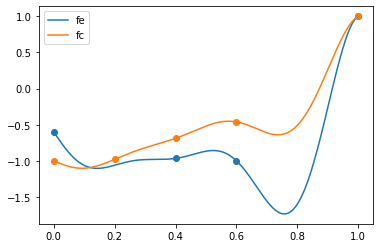

In [3]:
List=np.arange(0,1,0.001)
plt.plot(List,(fe(List)-1/2*(Y_max[1]+Y_min[1]))/(1/2*(Y_max[1]-Y_min[1])) , label='fe')
plt.plot(List,(fc(List)-1/2*(Y_max[0]+Y_min[0]))/(1/2*(Y_max[0]-Y_min[0])), label='fc')
plt.scatter(data_X[1],data_Y[1])
plt.scatter(data_X[0],data_Y[0])
plt.legend()

# Building the initial models

## coarse model 

In [4]:
k_1=gpflow.kernels.RBF(1)
theta=gpflow.kernels.Constant()
k[0]=k_1+theta 
model[0]=gpflow.models.GPR((data_X[0], data_Y[0]),k[0],noise_variance=1e-5)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model[0].training_loss,variables=model[0].trainable_variables,options=dict(disp=True, maxiter=100),)
sigma_epsilon[0]=np.sqrt(float(model[0].likelihood.variance.numpy()))
k_inv[0]=np.linalg.inv(k[0](data_X[0])+sigma_epsilon[0]**2*np.eye(n[0]))
def K_c(x):
    
    if isinstance(x, np.float64):
        K=k[0](x,data_X[0]).reshape((1,n[0]))
    else:
        K=k[0](x,data_X[0])
    return K.numpy().T


def k_coef_c(x):
    if len(x)==1:
        return k[0](x,x).numpy()
    else :
        return k[0](x,x).numpy().diagonal().reshape((len(x),1))
    
def predict_c(x):
    mean=np.dot(K_c(x).T,np.dot(k_inv[0],data_Y[0]))
    if len(x)==1:
        var=k_coef_c(x)+sigma_epsilon[0]**2-np.dot(K_c(x).T,np.dot(k_inv[0],K_c(x))).reshape(len(x),1)
    else:
        var=k_coef_c(x)+sigma_epsilon[0]**2-np.dot(K_c(x).T,np.dot(k_inv[0],K_c(x))).diagonal().reshape(len(x),1)    
    return mean,var 



2022-07-13 14:22:03.769734: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.15785D+02    |proj g|=  3.65927D+02

At iterate    1    f=  3.40313D+01    |proj g|=  1.58170D+02

At iterate    2    f=  4.58723D+00    |proj g|=  3.63979D+00

At iterate    3    f=  4.54067D+00    |proj g|=  3.06625D+00

At iterate    4    f=  4.40698D+00    |proj g|=  6.63164D-01

At iterate    5    f=  4.39629D+00    |proj g|=  2.10553D-01

At iterate    6    f=  4.39215D+00    |proj g|=  2.11386D-01

At iterate    7    f=  4.38475D+00    |proj g|=  3.38108D-01

At iterate    8    f=  4.36454D+00    |proj g|=  7.40391D-01

At iterate    9    f=  4.31501D+00    |proj g|=  1.25561D+00

At iterate   10    f=  4.22293D+00    |proj g|=  1.70861D+00

At iterate   11    f=  4.15078D+00    |proj g|=  1.69837D+00

At iterate   12    f=  3.92265D+00    |proj g|=  1.53150D+00

At iterate   13    f=  3.7

 This problem is unconstrained.


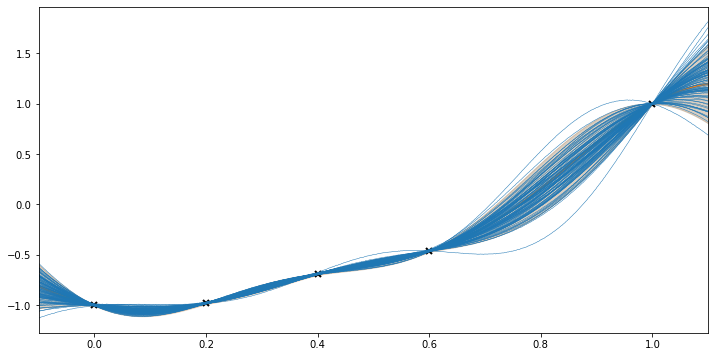

In [5]:
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

xx = np.linspace(-0.1, 1.1, 1000).reshape(1000, 1)  # test points must be of shape (N, D)


## predict mean and variance of latent GP at test points
mean_c, var_c = model[0].predict_f(xx)
mean, var=predict_c(xx)
## generate 10 samples from posterior
samples = model[0].predict_f_samples(xx, 100) # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(data_X[0], data_Y[0], 'kx', mew=2)
plt.plot(xx, mean_c, 'C0', label='predict_f',lw=2)
plt.plot(xx, mean, 'C1', label='predict_c', lw=2)
plt.fill_between(xx[:,0],
                 mean_c[:,0] - 1.96 * np.sqrt(var_c[:,0]),
                 mean_c[:,0] + 1.96 * np.sqrt(var_c[:,0]),
                 color='C0', alpha=0.2)

plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C1', alpha=0.2)
plt.plot(xx, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);

In [6]:
model[0]

<gpflow.models.gpr.GPR object at 0x7fcde701c310>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.679961    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.299384    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.7129e-07  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 2.16867e-05 │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════╛

## the MF-model 

In [7]:
prev_model_obsv,_=predict_c(data_X[1])

import math
def neg_log_likelihood(par, X_e,Y_e,Y_c):
    Ro,l,var,theta, sigma_epsilon=par 
    dist_X_e = (X_e - X_e.T)**2
    k = var*np.exp(-(1/(2*(l**2)))*dist_X_e)+theta
    n=len(X_e)
    return -(-n/2*np.log(2*np.pi)-1/2*np.log(np.linalg.det(k+(sigma_epsilon**2)*np.eye(n)))-1/2*np.dot(np.dot(( Y_e-Ro*Y_c).T,np.linalg.inv(k+(sigma_epsilon**2)*np.eye(n))),(Y_e-Ro*Y_c)))

from scipy.optimize import minimize 
start =  [0.1,0.1, 0.5,0.01,0.01]

min=minimize(neg_log_likelihood, start, args=(data_X[1],data_Y[1],prev_model_obsv), bounds=[(-np.inf,np.inf),(1.1e-6,2),(1e-4,30**2),(1e-4,np.inf),(1e-4,np.inf)],method='L-BFGS-B',options = {'disp':True,'maxiter':1000})

k_2=gpflow.kernels.RBF(min.x[2],min.x[1])
theta=gpflow.kernels.Constant(min.x[3])
k[1]=k_2+theta
ro=[min.x[0]]

sigma_epsilon[1]=min.x[4]
k_inv[1]=np.linalg.inv(k[1](data_X[1])+sigma_epsilon[1]**2*np.eye(n[1]))

def K_MF(x):

    if isinstance(x, np.float64):
        K=k[1](x,data_X[1]).reshape(1,n[1])
    else:
        
        K=k[1](x,data_X[1])
    return K.numpy().T



def k_coef_MF(x):
    if len(x)==1:
        return k[1](x,x).numpy()
    else :
        return k[1](x,x).numpy().diagonal().reshape((len(x),1))



def f_hat(x) :
    Y_e=data_Y[1]
    Y_c,var=predict_c(data_X[1])
    mean_c, var_c= predict_c(x)
    
    return (min.x[0]*mean_c+np.dot(np.dot(K_MF(x).T, k_inv[1]),Y_e-min.x[0]*Y_c))
def sigma_square_hat(x):
    mean_c, var_c= predict_c(x)
    
    if len(x)==1:
        
        return (pow(min.x[0],2)*var_c+sigma_epsilon[1]**2+k_coef_MF(x)-np.dot(np.dot(K_MF(x).T, k_inv[1]),K_MF(x)).reshape(len(x),1))
    else :
        return (pow(min.x[0],2)*var_c+sigma_epsilon[1]**2+k_coef_MF(x)-np.dot(np.dot(K_MF(x).T, k_inv[1]),K_MF(x)).diagonal().reshape(len(x),1))
    

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.86270D+00    |proj g|=  4.62136D+00

At iterate    1    f=  2.08990D+00    |proj g|=  3.04130D+00

At iterate    2    f=  1.63872D+00    |proj g|=  1.52361D+00

At iterate    3    f=  1.31776D+00    |proj g|=  2.30668D+00

At iterate    4    f=  9.67544D-01    |proj g|=  1.33382D+00

At iterate    5    f=  8.74135D-01    |proj g|=  8.20756D-01

At iterate    6    f=  8.53337D-01    |proj g|=  5.39776D-01

At iterate    7    f=  8.26134D-01    |proj g|=  1.20807D+00

At iterate    8    f=  6.05277D-01    |proj g|=  2.85534D+00

At iterate    9    f=  5.16472D-01    |proj g|=  5.15228D+00

At iterate   10    f=  1.06997D-01    |proj g|=  4.76675D+00

At iterate   11    f=  3.45564D-02    |proj g|=  1.83233D+01

At iterate   12    f= -3.08013D-01    |proj g|=  2.08799D+00

At iterate   13    f= -3.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [8]:
## plot 
plt.figure(figsize=(12, 6))
plt.plot(data_X[1], data_Y[1], 'kx', mew=2)
plt.plot(xx, f_hat(xx), 'C3', label='MF',lw=2)
#plt.plot(xx, mean_e, 'C2', label='HF',lw=2)
plt.plot(xx, mean_c, 'C5', label='Coarse',lw=2)
#plt.plot(xx, mean_e, 'C2', label='fine',lw=2)
plt.plot(xx,(fe(xx)-1/2*(Y_max[1]+Y_min[1]))/(1/2*(Y_max[1]-Y_min[1])),'C0', label="fe")

plt.fill_between(xx[:,0],
                f_hat(xx)[:,0] - 1.96 * np.sqrt(sigma_square_hat(xx)[:,0]),
                f_hat(xx)[:,0] + 1.96 * np.sqrt(sigma_square_hat(xx)[:,0]),
                color='C0', alpha=0.2)

plt.legend()

plt.xlim(-0.1, 1.1);

# proceeding with the optimization 

In [9]:
## the current effective best 
x_best=data_X[0][np.argmin(f_hat(data_X[0]))].reshape(1,dim)
x_best

array([[0.2]])

In [10]:



def u(x): 
   
    return (f_hat(x_best)-f_hat(x))/np.sqrt(sigma_square_hat(x))

from scipy.stats import norm
def EI(x):
    return (np.sqrt(sigma_square_hat(x))*[u(x)*norm.cdf(u(x))+norm.pdf(u(x))]).reshape(x.shape)

def AEI_L(x):
    return (EI(x)*(1-sigma_epsilon[1]/np.sqrt(sigma_square_hat(x)+sigma_epsilon[1]**2)))

def predictive_variance_update_NN(X,x_star,l_star=2):## X is  nD array 
    try:
        
        if isinstance(X,(np.float64,float)) :
            if l_star==1:
                M1= np.concatenate((K_c(X).T, k[0](X,x_star).numpy().reshape(1,1)),axis=1)
                array1=np.concatenate((k[0](data_X[0])+(sigma_epsilon[0])**2*np.eye(n[0]),K_c(x_star)),axis=1) 
                array2=np.concatenate((K_c(x_star).T,k_coef_c(x_star)+sigma_epsilon[0]**2),axis=1)                    
                M2=np.concatenate((array1,array2),axis=0)
                predictive_variance_update=np.dot(np.dot(M1,np.linalg.inv(M2)),M1.T)-np.dot(np.dot(K_c(X).T,k_inv[0]),K_c(X))
            elif l_star==2:
                M1= np.concatenate((K_MF(X).T, k[1](X,x_star).numpy().reshape(1,1)),axis=1)
                array1=np.concatenate((k[1](data_X[1])+(sigma_epsilon[1])**2*np.eye(n[1]),K_MF(x_star)),axis=1) 
                array2=np.concatenate((K_MF(x_star).T,k_coef_MF(x_star)+sigma_epsilon[1]**2),axis=1)                    
                M2=np.concatenate((array1,array2),axis=0)
                predictive_variance_update=np.dot(np.dot(M1,np.linalg.inv(M2)),M1.T)-np.dot(np.dot(K_MF(X).T,k_inv[1]),K_MF(X))
            return predictive_variance_update
        ## x_star id 1D array
        elif len(X)==1:
            X=X.reshape(1,1)
            if l_star==1:
                M1= np.concatenate((K_c(X).T, k[0](X,x_star).numpy().reshape(1,1)),axis=1)
                array1=np.concatenate((k[0](data_X[0])+(sigma_epsilon[0])**2*np.eye(n[0]),K_c(x_star)),axis=1) 
                array2=np.concatenate((K_c(x_star).T,k_coef_c(x_star)+sigma_epsilon[0]**2),axis=1)                    
                M2=np.concatenate((array1,array2),axis=0)
                predictive_variance_update=np.dot(np.dot(M1,np.linalg.inv(M2)),M1.T)-np.dot(np.dot(K_c(X).T,k_inv[0]),K_c(X))
            elif l_star==2:
                M1= np.concatenate((K_MF(X).T, k[1](X,x_star).numpy().reshape(1,1)),axis=1)
                array1=np.concatenate((k[1](data_X[1])+(sigma_epsilon[1])**2*np.eye(n[1]),K_MF(x_star)),axis=1) 
                array2=np.concatenate((K_MF(x_star).T,k_coef_MF(x_star)+sigma_epsilon[1]**2),axis=1)                    
                M2=np.concatenate((array1,array2),axis=0)
                predictive_variance_update=np.dot(np.dot(M1,np.linalg.inv(M2)),M1.T)-np.dot(np.dot(K_MF(X).T,k_inv[1]),K_MF(X))
            return predictive_variance_update
    except  TypeError:
        print('check dimension')
        
        
### nested case
def predictive_variance_update_N(X,x_star,l_star=2):
    
    s=0
    for l in range(1,l_star+1):
        P=1
        if l<(L) :
            for j in range(l,L): 
                P*=ro[j-1]**2
        s+=P*predictive_variance_update_NN(X,x_star,l)
        
    return s 

def max_(a,X):
    L=np.zeros((len(X),1))
    for i in range(len(X)):
        if(float(X[i])>a) :
            L[i]=X[i]
        else:
            L[i]=a
    return L
W=np.ones(L)
W[0]=1
W[1]=101

def MF_AEI_N(x,l=2):
    if isinstance(x, (np.float64, float)):
        update=predictive_variance_update_N(x,x,l)/sigma_square_hat(x)
    else: 
        update=np.zeros((len(x),1))
        for i in range(len(x)):
            update[i]=predictive_variance_update_N(x[i].reshape(1,1),x[i].reshape(1,1),l)/sigma_square_hat(x[i].reshape(1,1))
    return AEI_L(x)*sum(W)/sum(W[:l]) *max_(0,update)

def neg_MF_AEI_N_2(x):
    return -MF_AEI_N(x,2)
def neg_MF_AEI_N_1(x):
    return -MF_AEI_N(x,1)



def predict( model_, x) : 
    if (model_ is model[0]):
        return predict_c(x)
    elif (model_ is  model[1]):
        return f_hat(x)
    
    


f=[fc,fe]
best_observation=[x_best, 2] ### the initialization 






iteration : 0


/tmp/ipykernel_1987203/1915768965.py:24: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  best_observation_parallel[opt]=[min1.x.reshape(1,1),int(1)]


iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17308D+00    |proj g|=  4.20429D+01

At iterate    1    f=  5.54543D+00    |proj g|=  3.06181D+00

At iterate    2    f=  3.55481D+00    |proj g|=  2.11828D+00

At iterate    3    f=  3.50094D+00    |proj g|=  1.70660D-01

At iterate    4    f=  3.50026D+00    |proj g|=  7.78576D-02

At iterate    5    f=  3.49999D+00    |proj g|=  6.51468D-02

At iterate    6    f=  3.49946D+00    |proj g|=  1.16021D-01

At iterate    7    f=  3.49847D+00    |proj g|=  1.75063D-01

At iterate    8    f=  3.49755D+00    |proj g|=  1.23034D-01

At iterate    9    f=  3.49729D+00    |proj g|=  2.81068D-02

At iterate 

 This problem is unconstrained.


At iterate    3    f=  4.19341D+00    |proj g|=  4.15528D-01
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    4    f=  4.05890D+00    |proj g|=  1.56474D+00

At iterate    5    f=  3.23656D+00    |proj g|=  7.24087D+00

At iterate    6    f=  2.91076D+00    |proj g|=  1.96186D+00
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    7    f=  2.87193D+00    |proj g|=  1.44849D+00

At iterate    8    f=  2.79435D+00    |proj g|=  7.72869D-01

At iterate    9    f=  2.73394D+00    |proj g|=  7.37101D-01

At iterate   10    f=  2.22314D+00    |proj g|=  8.91824D-01

At iterate   11    f=  2.07602D+00    |proj g|=  1.76206D+00

At iterate   12    f=  1.94154D+00    |proj g|=  8.30027D-01

At iterate   13    f=  1.90164D+00    |proj g|=  3.25815D-01

At iterate   14    f=  1.89866D+00    |proj g|=  5.11992D-01

At iterate   15    f=  1.89519D+00    |proj g|=  5.69905D-02

At iterate   16    f=  1.89513D+00    |proj g|=  3

/tmp/ipykernel_1987203/2758693064.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  k = var*np.exp(-(1/(2*(l**2)))*dist_X_e)+theta
/tmp/ipykernel_1987203/2758693064.py:7: RuntimeWarning: invalid value encountered in multiply
  k = var*np.exp(-(1/(2*(l**2)))*dist_X_e)+theta
/usr/lib64/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39006D+00    |proj g|=  7.60011D+01

At iterate    1    f=  8.98089D-01    |proj g|=  3.46836D+00

At iterate    2    f= -8.52790D-01    |proj g|=  2.31144D+00

At iterate    3    f= -9.47529D-01    |proj g|=  1.53633D+00

At iterate    4    f= -1.00272D+00    |proj g|=  1.42140D+00

At iterate    5    f= -1.02850D+00    |proj g|=  4.38193D-01

At iterate    6    f= -1.27494D+00    |proj g|=  1.01372D+00

At iterate    7    f= -1.73759D+00    |proj g|=  2.07344D+00

At iterate    8    f= -1.91367D+00    |proj g|=  1.72407D+00

At iterate    9    f= -2.04767D+00    |proj g|=  4.87738D-01

At iterate 

 This problem is unconstrained.


iteration : 1
iteration : 2
iteration : 3
iteration : 4


/tmp/ipykernel_1987203/1915768965.py:20: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  best_observation_parallel[opt]=[min2.x.reshape(1,1),int(2)]


iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28480D-01    |proj g|=  1.88112D+01

At iterate    1    f= -1.28258D+00    |proj g|=  3.04290D+00

At iterate    2    f= -1.39856D+00    |proj g|=  2.04675D+00

At iterate    3    f= -1.45444D+00    |proj g|=  1.54146D+00

At iterate    4    f= -1.47830D+00    |proj g|=  4.38527D-01

At iterate    5    f= -1.50020D+00    |proj g|=  5.39847D-01

At iterate    6    f= -1.56744D+00    |proj g|=  1.69489D+00

At iterate    7    f= -1.78068D+00    |proj g|=  4.17275D+00

At iterate    8    f= -2.14661D+00    |proj g|=  5.75065D+00

At iterate    9    f= -2.45759D+00    |proj g|=  2.93796D+00

At iterate   10    f= -2.56024D+00    |proj g|=  8.70155D-01

At iterate   11    f= -2.58098D+00    |proj g|=  6.35016D-02

At iterate   12    f= -2.58598D+00    |proj g|=  2.44832D-01

At iterate   13    f= -2.5

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.12560D+00    |proj g|=  4.79568D+00

At iterate    1    f= -3.32554D+00    |proj g|=  1.04507D+00

At iterate    2    f= -3.33848D+00    |proj g|=  5.60089D-01

At iterate    3    f= -3.37142D+00    |proj g|=  5.52565D-01

At iterate    4    f= -3.65736D+00    |proj g|=  2.28441D+00

At iterate    5    f= -3.87330D+00    |proj g|=  1.82246D+00

At iterate    6    f= -4.12528D+00    |proj g|=  1.99895D+00

At iterate    7    f= -4.43597D+00    |proj g|=  3.42025D+00

At iterate    8    f= -4.57527D+00    |proj g|=  1.34769D+00

At iterate    9    f= -4.60163D+00    |proj g|=  3.56364D-01

At iterate   10    f= -4.60898D+00    |proj g|=  4.88702D-01

At iterate   11    f= -4.62026D+00    |proj g|=  1.42875D-01

At iterate   12    f= -4.62410D+00    |proj g|=  1.07693D-02

At iterate   13    f= -4.6

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.45714D+00    |proj g|=  9.09557D-01

At iterate    1    f= -7.46081D+00    |proj g|=  2.36313D+00

At iterate    2    f= -7.48799D+00    |proj g|=  1.06965D+00

At iterate    3    f= -7.52829D+00    |proj g|=  8.98725D-01

At iterate    4    f= -7.62511D+00    |proj g|=  2.89223D+00

At iterate    5    f= -7.89559D+00    |proj g|=  7.44329D+00

At iterate    6    f= -8.50871D+00    |proj g|=  1.21104D+01

At iterate    7    f= -9.29321D+00    |proj g|=  6.82797D+00

At iterate    8    f= -9.46869D+00    |proj g|=  2.23184D+00

At iterate    9    f= -9.51055D+00    |proj g|=  2.73477D-01

At iterate   10    f= -9.51937D+00    |proj g|=  5.33675D-01

At iterate   11    f= -9.52575D+00    |proj g|=  7.28589D-01

At iterate   12    f= -9.54051D+00    |proj g|=  6.44151D-01

At iterate   13    f= -9.5

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20321D+01    |proj g|=  1.35948D+00

At iterate    1    f= -1.21282D+01    |proj g|=  4.58098D+00

At iterate    2    f= -1.30349D+01    |proj g|=  1.17145D+00

At iterate    3    f= -1.46597D+01    |proj g|=  1.59555D+01

At iterate    4    f= -1.51496D+01    |proj g|=  3.82943D+00

At iterate    5    f= -1.52050D+01    |proj g|=  1.72408D+00

At iterate    6    f= -1.52287D+01    |proj g|=  6.46841D-01

At iterate    7    f= -1.52361D+01    |proj g|=  5.42571D-01

At iterate    8    f= -1.52593D+01    |proj g|=  1.77420D-01

At iterate    9    f= -1.52719D+01    |proj g|=  1.51276D-01

At iterate   10    f= -1.52841D+01    |proj g|=  5.03903D-02

At iterate   11    f= -1.52850D+01    |proj g|=  1.30543D-02

At iterate   12    f= -1.52861D+01    |proj g|=  3.32200D-02

At iterate   13    f= -1.5

 This problem is unconstrained.


<Figure size 432x288 with 0 Axes>

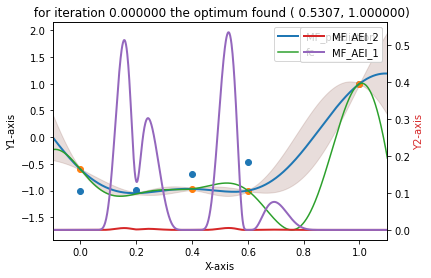

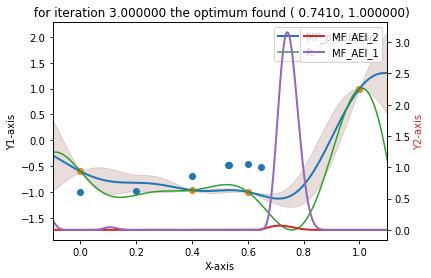

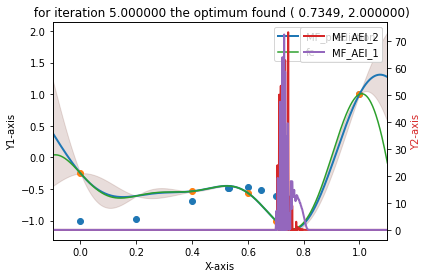

In [11]:
num_iter=7
num_parallel_optimizations=15
plt.figure()
step=1/num_parallel_optimizations
for i in range(num_iter):
    
    
    best_observation_parallel=np.zeros((num_parallel_optimizations,2))
    neg_MF_aei=np.zeros((num_parallel_optimizations,1))
    for opt in range(num_parallel_optimizations):
        x_0=(opt+1)*step*np.random.random_sample()+opt*step
        print("iteration :", opt)
        min1=minimize(neg_MF_AEI_N_1, float(x_0), args=(),bounds=[(0,1)],method='L-BFGS-B',options={'disp': None   ,'maxiter':15000, })
        
        min2=minimize(neg_MF_AEI_N_2, float(x_0), args=(),bounds=[(0,1)],method='L-BFGS-B',options={'disp': None, 'maxiter': 15000,  })
    
    
        if (min1.fun>min2.fun) :
        
            best_observation_parallel[opt]=[min2.x.reshape(1,1),int(2)]
            
            neg_MF_aei[opt]=min2.fun
        else :
            best_observation_parallel[opt]=[min1.x.reshape(1,1),int(1)]
            neg_MF_aei[opt]=min1.fun
            
            
    best_observation=best_observation_parallel[np.argmin(neg_MF_aei)]
    
    
    ## plots
    fig, ax1 = plt.subplots()
    mean = f_hat(xx)
    var=sigma_square_hat(xx)
    color = 'tab:red'
    ax1.set_xlabel('X-axis')  
    ax1.set_ylabel('Y1-axis')  
    ax1.plot(xx, mean, 'C0',label='MF_prediction ', lw=2)
    plt.plot(xx,(f[1](xx)-1/2*(Y_max[1]+Y_min[1]))/(1/2*(Y_max[1]-Y_min[1])),'C2', label="fe")
    ax1.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C5', alpha=0.2)
    plt.scatter(data_X[0],data_Y[0])
    plt.scatter(data_X[1],data_Y[1])
    ax1.tick_params(axis ='y')  
    plt.legend()
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Y2-axis', color = color) 
    ax2.plot(xx,MF_AEI_N(xx,2),'C3',label='MF_AEI_2',lw=2) 
    ax2.plot(xx,MF_AEI_N(xx,1),'C4',label='MF_AEI_1',lw=2) 
    ax2.tick_params(axis ='y')
    plt.title(' for iteration %f the optimum found ( %.4f, %f)' %(i,best_observation[0],best_observation[1]))
    plt.legend()
    plt.xlim(-0.1, 1.1);



    ## update the design of experiment  with the new observation 
    for l in range(int(best_observation[1])):
        n[l]+=1
        data_X[l]=np.concatenate([data_X[l],best_observation[0].reshape(1,1)])
        Y_best=f[l](best_observation[0].reshape(1,1))
        Y[l]=np.concatenate([Y[l],Y_best])
        Y_max[l]=np.max(Y[l])
        Y_min[l]=np.min(Y[l])
        data_Y[l]=normalization(Y[l])

        
    
    ##optimize all your models ( because we're using the recursive method)
    for j in range(L) :
        
        if (j==0): 
            model[j]=gpflow.models.GPR((data_X[j], data_Y[j]),k[j],noise_variance=1e-5)
            optimizer.minimize(model[j].training_loss,variables=model[j].trainable_variables,options=dict(disp=True, maxiter=1000),)
            sigma_epsilon[j]=float(model[j].likelihood.variance.numpy())
            k_inv[j]=np.linalg.inv(k[j](data_X[j])+sigma_epsilon[j]*np.eye(n[j]))
        else :
            start =  [ro[j-1],min.x[1],min.x[2],min.x[3],sigma_epsilon[j]]
            prev_model_obs,_=predict(model[j-1],data_X[j])
            min=minimize(neg_log_likelihood, start, args=(data_X[j],data_Y[j],prev_model_obs), bounds=[(-np.inf,np.inf),(0e-4,2),(1e-4,30**2),(1e-4,np.inf),(1.1e-6,np.inf)],method='L-BFGS-B',options = {'disp':True,'maxiter':1000})
            ro[j-1]=min.x[0]
            sigma_epsilon[j]=min.x[4]
            k_=gpflow.kernels.RBF(min.x[2],min.x[1])
            theta=gpflow.kernels.Constant(min.x[3])
            k[j]=k_+theta
            k_inv[j]=np.linalg.inv(k[j](data_X[j])+sigma_epsilon[j]*np.eye(n[j]))
         

    DoE=data_X[0] ##desig of experiment 
    x_best=DoE[np.argmin(f_hat(DoE))].reshape(1,dim)

